In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/rahulgupta/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def generate_local_volatility_surface(strikes, model='constant', params=None):
    """Generate local volatility within the range [0, 20] based on the selected model."""
    sigma_surface = np.zeros(len(strikes))  # Initialize array

    if model == 'constant':
        sigma_surface[:] = np.clip(params['sigma'], 0, 20)  # Clip to range [0, 20]

    elif model == 'normal':
        sigma_0 = params['sigma_0']
        S_0 = params['S_0']
        sigma_param = params['sigma_param']
        sigma_surface = sigma_0 * np.exp(-((strikes - S_0) ** 2) / (2 * sigma_param ** 2))
        sigma_surface = np.interp(sigma_surface, (sigma_surface.min(), sigma_surface.max()), (0, 20))  # Rescale to [0,20]

    elif model == 'linear':
        sigma_0 = params['sigma_0']
        beta = params['beta']
        sigma_surface = sigma_0 + beta * (strikes - params['S_0'])
        sigma_surface = np.clip(sigma_surface, 0, 20)  # Clip to valid range

    return sigma_surface

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def generate_local_volatility_surface(strikes, model='constant', params=None):
    """Generate local volatility for given strikes based on the specified model."""
    sigma_surface = np.zeros(len(strikes))  # Initialize array

    if model == 'constant':
        sigma_surface[:] = params['sigma']

    elif model == 'normal':
        sigma_0 = params['sigma_0']
        S_0 = params['S_0']
        sigma_param = params['sigma_param']
        sigma_surface = sigma_0 * np.exp(-((strikes - S_0) ** 2) / (2 * sigma_param ** 2))

    elif model == 'linear':
        sigma_0 = params['sigma_0']
        beta = params['beta']
        sigma_surface = sigma_0 + beta * (strikes - params['S_0'])
        sigma_surface = np.clip(sigma_surface, 0.05, 1.0)  # Ensure positive volatilities

    return sigma_surface

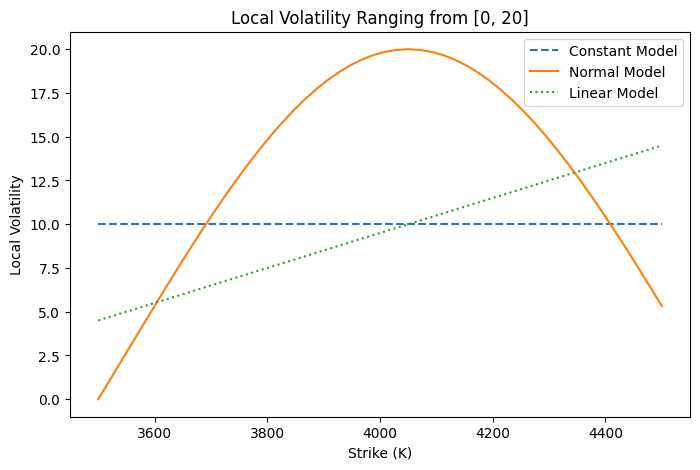

In [16]:
# Market settings
S = 4050  # Underlying price
strikes = np.linspace(3500, 4500, 50)  # Strike prices

# Adjusted Constant Model
params_constant = {'sigma': 10}  # Midpoint of [0, 20]
sigma_constant = generate_local_volatility_surface(strikes, model='constant', params=params_constant)

# Adjusted Normal Model
params_normal = {'sigma_0': 10, 'S_0': S, 'sigma_param': 500}
sigma_normal = generate_local_volatility_surface(strikes, model='normal', params=params_normal)

# Adjusted Linear Model
params_linear = {'sigma_0': 10, 'S_0': S, 'beta': 0.01}
sigma_linear = generate_local_volatility_surface(strikes, model='linear', params=params_linear)

# Plot the adjusted volatility models
plt.figure(figsize=(8, 5))
plt.plot(strikes, sigma_constant, label="Constant Model", linestyle="dashed")
plt.plot(strikes, sigma_normal, label="Normal Model")
plt.plot(strikes, sigma_linear, label="Linear Model", linestyle="dotted")
plt.xlabel("Strike (K)")
plt.ylabel("Local Volatility")
plt.title("Local Volatility Ranging from [0, 20]")
plt.legend()
plt.show()

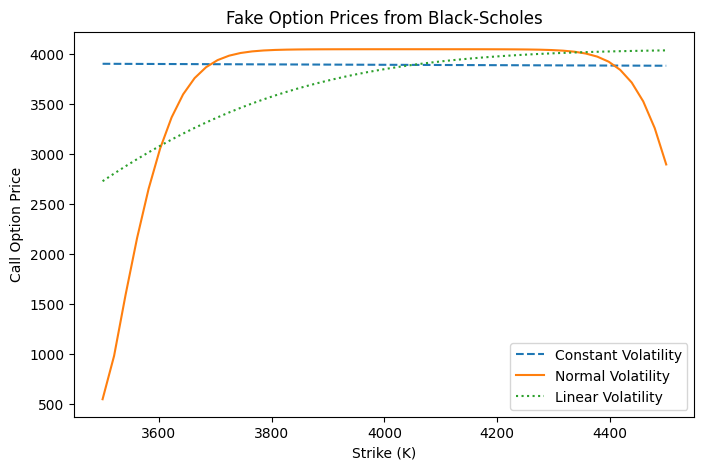

In [12]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """Compute Black-Scholes call option price."""
    if sigma == 0:  # Handle case where volatility is exactly 0
        return max(S - K, 0)
    
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Market parameters
S = 4050  # Current underlying price
T = 43 / 252  # Time to expiry (in years)
r = 0.05  # Risk-free rate
strikes = np.linspace(3500, 4500, 50)  # Strike prices

# Generate local volatilities for each model (within [0, 20])
sigma_constant = generate_local_volatility_surface(strikes, model='constant', params=params_constant)
sigma_normal = generate_local_volatility_surface(strikes, model='normal', params=params_normal)
sigma_linear = generate_local_volatility_surface(strikes, model='linear', params=params_linear)

# Compute option prices for each model
option_prices_constant = np.array([black_scholes_call(S, K, T, r, sigma) for K, sigma in zip(strikes, sigma_constant)])
option_prices_normal = np.array([black_scholes_call(S, K, T, r, sigma) for K, sigma in zip(strikes, sigma_normal)])
option_prices_linear = np.array([black_scholes_call(S, K, T, r, sigma) for K, sigma in zip(strikes, sigma_linear)])

# Plot the option prices
plt.figure(figsize=(8, 5))
plt.plot(strikes, option_prices_constant, label="Constant Volatility", linestyle="dashed")
plt.plot(strikes, option_prices_normal, label="Normal Volatility")
plt.plot(strikes, option_prices_linear, label="Linear Volatility", linestyle="dotted")
plt.xlabel("Strike (K)")
plt.ylabel("Call Option Price")
plt.title("Fake Option Prices from Black-Scholes")
plt.legend()
plt.show()

/var/folders/mj/rwsfcy551jd8ltwbtw8d_bz00000gn/T/ipykernel_18533/4240048944.py:15: RuntimeWarning: invalid value encountered in sqrt
  volatilities[i] = np.sqrt(numerator / denominator)


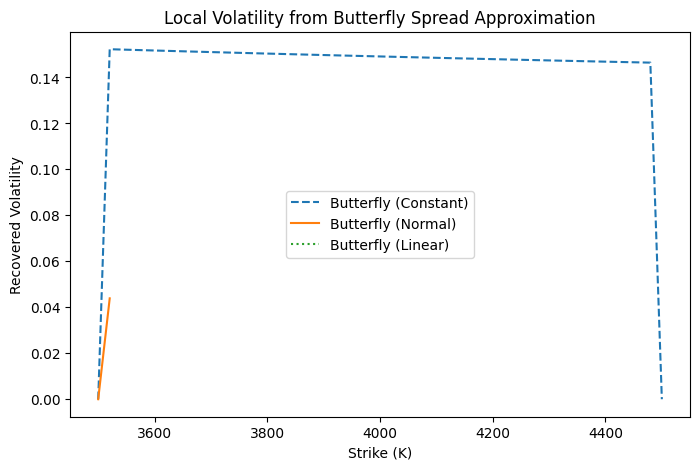

In [18]:
def compute_volatility_butterfly(K_vals, option_prices, T, r):
    """Compute local volatility using the butterfly spread approximation."""
    dK = K_vals[1] - K_vals[0]  # Assume uniform spacing
    volatilities = np.zeros(len(K_vals))
    
    for i in range(1, len(K_vals)-1):
        C_plus = option_prices[i + 1]
        C = option_prices[i]
        C_minus = option_prices[i - 1]
        
        numerator = 2 * np.exp(r * T) * (C_plus - 2 * C + C_minus)
        denominator = T * (C_plus - C_minus) ** 2
        
        if denominator > 0:
            volatilities[i] = np.sqrt(numerator / denominator)
        else:
            volatilities[i] = np.nan  # Avoid division by zero

    return volatilities

# Compute butterfly spread volatilities for each volatility model
vol_butterfly_constant = compute_volatility_butterfly(strikes, option_prices_constant, T, r)
vol_butterfly_normal = compute_volatility_butterfly(strikes, option_prices_normal, T, r)
vol_butterfly_linear = compute_volatility_butterfly(strikes, option_prices_linear, T, r)

# Plot recovered volatilities
plt.figure(figsize=(8, 5))
plt.plot(strikes, vol_butterfly_constant, label="Butterfly (Constant)", linestyle="dashed")
plt.plot(strikes, vol_butterfly_normal, label="Butterfly (Normal)")
plt.plot(strikes, vol_butterfly_linear, label="Butterfly (Linear)", linestyle="dotted")
plt.xlabel("Strike (K)")
plt.ylabel("Recovered Volatility")
plt.title("Local Volatility from Butterfly Spread Approximation")
plt.legend()
plt.show()

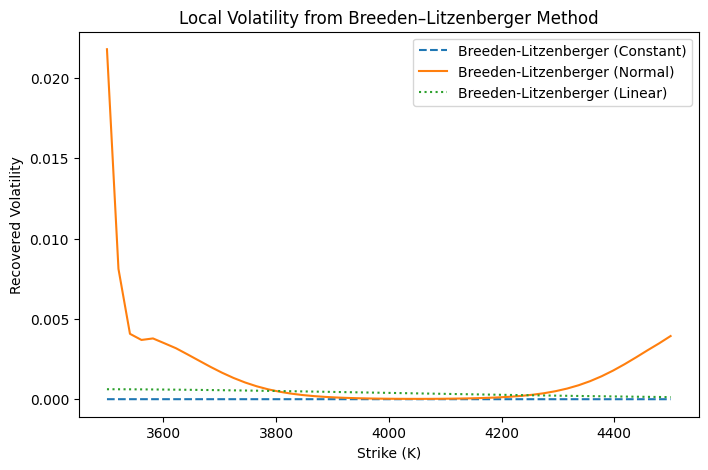

In [19]:
def compute_volatility_breeden_litzenberger(K_vals, option_prices, rnd, T):
    """Compute implied volatility using Breeden–Litzenberger method."""
    volatilities = np.sqrt(T * np.abs(rnd / option_prices))
    return np.nan_to_num(volatilities)  # Replace NaN with 0 for stability

# Compute Breeden-Litzenberger volatilities
vol_breeden_constant = compute_volatility_breeden_litzenberger(strikes, option_prices_constant, rnd_constant, T)
vol_breeden_normal = compute_volatility_breeden_litzenberger(strikes, option_prices_normal, rnd_normal, T)
vol_breeden_linear = compute_volatility_breeden_litzenberger(strikes, option_prices_linear, rnd_linear, T)

# Plot recovered volatilities
plt.figure(figsize=(8, 5))
plt.plot(strikes, vol_breeden_constant, label="Breeden-Litzenberger (Constant)", linestyle="dashed")
plt.plot(strikes, vol_breeden_normal, label="Breeden-Litzenberger (Normal)")
plt.plot(strikes, vol_breeden_linear, label="Breeden-Litzenberger (Linear)", linestyle="dotted")
plt.xlabel("Strike (K)")
plt.ylabel("Recovered Volatility")
plt.title("Local Volatility from Breeden–Litzenberger Method")
plt.legend()
plt.show()